In [62]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import math
import os

from scipy.spatial import Delaunay
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely import affinity
import json
import warnings
import random

from scipy.optimize import minimize
from scipy.spatial import cKDTree
from scipy.special import gammaln
from sklearn.metrics.pairwise import euclidean_distances
from shapely import wkt as shapely_wkt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt



In [2]:
INPUT_PATH = Path("final_data.csv")
OUTPUT_PATH = Path("final_data_cleaned.csv")


In [3]:
# ====== تنظیمات کاربر ======
mag_col = "MAG"              # نام ستون مگنیتود اصلی (اگر در فایل فرق دارد تغییر بده)
min_magnitude = 4.0          # نمونه فیلتر: فقط رخدادهایی با مگنی‌تود >= این مقدار را نگه دار
# ===========================



In [4]:
def try_read_csv(path: Path):
    """سعی می‌کند فایل را با چند جداکننده بخواند (tab, comma, whitespace)."""
    for sep, kwargs in [
        ("\t", {"engine": "python"}),
        (",", {"engine": "python"}),
        (r"\s+", {"engine": "python", "delim_whitespace": True}),
    ]:
        try:
            df = pd.read_csv(path, sep=sep, header=0, **kwargs)
            # اگر از ردیف اول بعنوان header استفاده نشده بود، ستون‌های غیراستاندارد را اصلاح کنیم
            if df.shape[1] < 3:
                continue
            print(f"خوانده شد با جداکننده: {repr(sep)} — shape: {df.shape}")
            return df
        except Exception as e:
            # print(f"خواندن با sep={sep} خطا داد: {e}")
            continue
    raise ValueError(f"نشد فایل را با جداکننده‌های معمول بخوانیم: {path}")


In [5]:
def clean_colnames(df: pd.DataFrame):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def replace_na_strings(df: pd.DataFrame):
    df = df.copy()
    # معمولاً رشته 'NaN' یا 'nan' یا '' دیده میشه — همه را به np.nan تبدیل کن
    df = df.replace(["NaN", "nan", "NAN", "", "NULL", "null"], np.nan)
    return df


In [6]:
def str_to_float_safe(s):
    """تبدیل ایمن رشته‌هایی مثل '1,234' یا '-0.1v' یا '7KM' به float.
       اگر تبدیل نشد، None برمی‌گرداند."""
    if s is None:
        return None
    if isinstance(s, (int, float, np.floating, np.integer)):
        return float(s)
    s = str(s).strip()
    if s == "" or s.lower() in ["nan", "none", "null"]:
        return None
    # برداشتن قسمت‌هایی که مشخصاً غیر عددی اند، مثل 'v'، 'KM', 'km', 'm', '+' یا '±' و غیره
    # اما قبل از حذف علامت منفی/مثبت و ممیز، اعداد با کاما را به نقطه تبدیل کن
    s = s.replace(",", ".")
    # حذف +/±/+/- و پسوندهای متداول
    s = re.sub(r"[\u00B1±\+\/\-]*\s*\+?/?-?\s*\d+(\.\d+)?", "", s)  # remove trailing ±0.10 or +/-0.10
    # حذف واحدهای ساده
    s = re.sub(r"(km|KM|m|M|s|S|v|V|mm|MM|sec|SEC)$", "", s).strip()
    # حالا استخراج اولین عدد اعشاری موجود در رشته
    m = re.search(r"[-+]?\d*\.?\d+", s)
    if m:
        try:
            return float(m.group(0))
        except:
            return None
    return None


In [7]:
def col_to_numeric(df: pd.DataFrame, colnames):
    """ستون(ها) را با str_to_float_safe به عدد تبدیل کند و در صورت خطا np.nan بگذارد."""
    for col in colnames:
        if col not in df.columns:
            continue
        df[col + "_raw"] = df[col]  # نگه داشتن نسخه خام برای بازرسی
        df[col] = df[col].apply(str_to_float_safe)
    return df


In [8]:
def parse_event_time(s):
    """پارسر نمونه برای event_timeهایی مثل:
       '2019Y  6M 21D  0H  0M 16.05S +/-0.10 EASTERN F...'
       خروجی: datetime یا None
    """
    if pd.isna(s):
        return None
    s = str(s)
    # پیدا کردن الگو year Y, month M, day D, hour H, minute M, second S
    m = re.search(
        r"(?P<Y>\d{4})\s*Y.*?(?P<M>\d{1,2})\s*M.*?(?P<D>\d{1,2})\s*D.*?(?P<h>\d{1,2})\s*H.*?(?P<m>\d{1,2})\s*M.*?(?P<s>\d{1,2}(?:\.\d+)?)\s*S",
        s,
        flags=re.IGNORECASE | re.DOTALL,
    )
    if not m:
        # گاهی فرمت ساده‌تری وجود دارد؛ سعی کن اعداد ترتیبی را پیدا کنی
        nums = re.findall(r"\d{1,4}\.\d+|\d{1,4}", s)
        if len(nums) >= 6:
            try:
                Y, M, D, h, mm, ss = nums[:6]
                return datetime(
                    int(Y), int(M), int(D), int(h), int(mm), int(float(ss))
                )
            except Exception:
                return None
        return None
    try:
        Y = int(m.group("Y"))
        M = int(m.group("M"))
        D = int(m.group("D"))
        h = int(m.group("h"))
        mm = int(m.group("m"))
        ss = float(m.group("s"))
        sec = int(ss)
        micro = int((ss - sec) * 1_000_000)
        return datetime(Y, M, D, h, mm, sec, micro)
    except Exception:
        return None


In [9]:
def parse_latlon(s):
    """تبدیل '37 04.44N +/-0.30' یا '29 32.46N' به مقدار اعشاری (مثبت/منفی بر اساس N/S/E/W)."""
    if pd.isna(s):
        return None
    s = str(s).strip()
    # حذف قسمت +/-
    s = re.sub(r"\+/-.*", "", s)
    # الگوی درجه دقیقه و جهت
    m = re.search(r"(?P<deg>\d{1,3})\s+?(?P<min>\d{1,2}(?:\.\d+)?)\s*([°']*)\s*(?P<dir>[NSEW])", s, flags=re.IGNORECASE)
    if m:
        deg = float(m.group("deg"))
        minute = float(m.group("min"))
        direction = m.group("dir").upper()
        dec = deg + minute / 60.0
        if direction in ("S", "W"):
            dec = -dec
        return dec
    # اگر فقط یک عدد اعشاری باشد، تلاش برای تبدیل مستقیم
    m2 = re.search(r"[-+]?\d+\.?\d*", s)
    if m2:
        try:
            return float(m2.group(0))
        except:
            return None
    return None



In [10]:
def parse_depth(s):
    """استخراج عدد از '7KM' یا '7KM +/-1.58' به کیلومتر (float)."""
    if pd.isna(s):
        return None
    s = str(s).strip()
    s = s.replace(",", ".")
    m = re.search(r"(\d+\.?\d*)", s)
    if m:
        try:
            return float(m.group(1))
        except:
            return None
    return None

def extract_first_numeric_from_comma_field(s):
    """برای فیلدهایی مثل '2, 56' تلاش می‌کنیم عدد اول را استخراج کنیم."""
    if pd.isna(s):
        return None
    s = str(s)
    # split by comma or whitespace
    parts = re.split(r"[,\s]+", s.strip())
    for p in parts:
        num = str_to_float_safe(p)
        if num is not None:
            return num
    return None


In [11]:
def main():
    # 1) خواندن فایل
    df = try_read_csv(INPUT_PATH)

    # 2) پاک‌سازی نام ستون‌ها و مقادیر NaN به شکل مناسب
    df = clean_colnames(df)
    df = replace_na_strings(df)

    # 3) برخی ستون‌های عددی/مهم که معمولاً باید به float تبدیل شوند
    numeric_candidates = [
        "MAG", "MAG1", "MRES", "NS_AMP", "EW_AMP", "UD_AMP", "RES1", "RES2"
    ]
    # فقط ستون‌هایی که وجود دارند را لیست کن
    numeric_candidates = [c for c in numeric_candidates if c in df.columns]
    df = col_to_numeric(df, numeric_candidates)

    # 4) پارس کردن event_time
    if "event_time" in df.columns:
        df["event_time_parsed"] = df["event_time"].apply(parse_event_time)
    else:
        print("ستون event_time وجود ندارد.")

    # 5) تبدیل LAT و LONG
    if "LAT" in df.columns:
        df["LAT_dec"] = df["LAT"].apply(parse_latlon)
    if "LONG" in df.columns:
        df["LONG_dec"] = df["LONG"].apply(parse_latlon)

    # 6) DEPTH
    if "DEPTH" in df.columns:
        df["DEPTH_km"] = df["DEPTH"].apply(parse_depth)

    # 7) ستون R (اگر فرمت '2, 56' یا شبیه آن دارد)
    if "R" in df.columns:
        df["R_num"] = df["R"].apply(extract_first_numeric_from_comma_field)

    # 8) رفع مقادیر غیرعادی در سایر ستون‌هایی که ممکن است رشته‌ای عدد داشته باشند
    # (مثلاً مقادیر '-0.1v' یا '0.1 0.010') — برای هر ستون از numeric_candidates دوباره اطمینان حاصل کن
    for c in numeric_candidates:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 9) مثالِ فیلتر امن بر مبنای مگنی‌تود
    if mag_col in df.columns:
        # ابتدا نوع ستون را عددی کن (اگر از قبل تبدیل نشده)
        df[mag_col] = pd.to_numeric(df[mag_col], errors="coerce")
        # حالا فیلتر
        df_filtered = df[df[mag_col] >= min_magnitude].copy()
        print(f"تعداد رکوردها قبل از فیلتر: {len(df)}, بعد از فیلتر (MAG >= {min_magnitude}): {len(df_filtered)}")
    else:
        df_filtered = df.copy()
        print(f"ستون مگنیتود ({mag_col}) در داده نیست؛ فیلتر انجام نشد.")

    # 10) برخی عملیات نهایی: حذف تکراری‌ها و مرتب‌سازی بر حسب زمان (اگر موجود است)
    if "event_time_parsed" in df_filtered.columns:
        df_filtered = df_filtered.sort_values(by="event_time_parsed")
    df_filtered = df_filtered.drop_duplicates()

    # 11) ذخیره
    df_filtered.to_csv(OUTPUT_PATH, index=False)
    print(f"فایل پاک‌شده ذخیره شد: {OUTPUT_PATH}")

    # 12) گزارش خلاصه کوتاه
    print("\nخلاصه ستون‌ها و نوع داده‌ها:")
    print(df_filtered.dtypes)
    print("\nمقداری از داده‌ها (۵ سطر اول):")
    print(df_filtered.head(5))


In [12]:
if __name__ == "__main__":
    main()


خوانده شد با جداکننده: ',' — shape: (4320695, 22)
تعداد رکوردها قبل از فیلتر: 4320695, بعد از فیلتر (MAG >= 4.0): 0
فایل پاک‌شده ذخیره شد: final_data_cleaned.csv

خلاصه ستون‌ها و نوع داده‌ها:
STATION                         str
PHA1                            str
TIME1                           str
RES1                        float64
PHA2                            str
TIME2                           str
RES2                        float64
NS_AMP                      float64
EW_AMP                      float64
UD_AMP                      float64
DELTA                           str
AZM                             str
MAG                         float64
MRES                        float64
event_time                      str
event_place                 float64
R                               str
LAT                             str
LONG                            str
DEPTH                           str
MAG1                        float64
source_file                     str
MAG_raw         

In [14]:
# ==============================
# تنظیمات اصلی (قابل تغییر)
# ==============================

FILE_PATH = "final_data.csv"

m_min = 3.0
q_min = 0.8
d_max = 700
k_neighbors = 5

# اگر محدوده مطالعه داری اینجا بگذار
LAT_RANGE = None     # مثلا (25, 45)
LON_RANGE = None     # مثلا (125, 150)

# ==============================
# توابع تبدیل


In [15]:
def parse_latlon(val):
    """ تبدیل '37 04.44N' به decimal """
    if pd.isna(val):
        return np.nan

    val = str(val)
    val = re.sub(r"\+/-.*", "", val)

    match = re.search(r'(\d+)\s+(\d+\.?\d*)([NSEW])', val)

    if match:
        deg = float(match.group(1))
        minutes = float(match.group(2))
        direction = match.group(3)

        dec = deg + minutes/60

        if direction in ['S', 'W']:
            dec *= -1

        return dec

    return np.nan



In [16]:
def parse_depth(val):
    """ استخراج عدد از '7KM' """
    if pd.isna(val):
        return np.nan

    match = re.search(r"\d+\.?\d*", str(val))

    return float(match.group()) if match else np.nan


def parse_time(val):
    """ تبدیل event_time به datetime """
    if pd.isna(val):
        return pd.NaT

    nums = re.findall(r'\d+\.?\d*', str(val))

    if len(nums) >= 6:
        Y, M, D, h, m, s = nums[:6]

        return pd.Timestamp(
            int(Y),
            int(M),
            int(D),
            int(h),
            int(m),
            int(float(s))
        )

    return pd.NaT


In [17]:
# ==============================
# خواندن داده
# ==============================

df = pd.read_csv(FILE_PATH, sep=None, engine='python')

print("Initial size:", len(df))

# ==============================
# تبدیل ستون‌ها
# ==============================

df["LAT"] = df["LAT"].apply(parse_latlon)
df["LONG"] = df["LONG"].apply(parse_latlon)
df["DEPTH"] = df["DEPTH"].apply(parse_depth)

df["event_time"] = df["event_time"].apply(parse_time)

# تبدیل magnitude
if "MAG" in df.columns:
    df["MAG"] = pd.to_numeric(df["MAG"], errors='coerce')
elif "MAG1" in df.columns:
    df["MAG"] = pd.to_numeric(df["MAG1"], errors='coerce')
else:
    raise ValueError("No magnitude column found!")

# حذف NaN های حیاتی
df = df.dropna(subset=["LAT","LONG","MAG","event_time"])

print("After basic cleaning:", len(df))




Initial size: 4320695
After basic cleaning: 186822


In [18]:
# =====================================================
# 1️⃣ فیلتر زمانی (Magnitude)
# =====================================================

df = df[df["MAG"] >= m_min]

print("After magnitude filter:", len(df))



After magnitude filter: 1317


In [19]:
# =====================================================
# 2️⃣ حذف ثبت‌های تکراری
# (کمتر از 1 ثانیه در همان مکان)
# =====================================================

df = df.sort_values("event_time")

time_diff = df["event_time"].diff().dt.total_seconds()

same_location = (
    (df["LAT"].diff().abs() < 1e-4) &
    (df["LONG"].diff().abs() < 1e-4)
)

duplicates = (time_diff < 1) & same_location

df = df[~duplicates]

print("After duplicate removal:", len(df))

After duplicate removal: 1151


In [20]:
# =====================================================
# 3️⃣ فیلتر مکانی (در صورت تعریف محدوده)
# =====================================================

if LAT_RANGE:
    df = df[(df["LAT"] >= LAT_RANGE[0]) & (df["LAT"] <= LAT_RANGE[1])]

if LON_RANGE:
    df = df[(df["LONG"] >= LON_RANGE[0]) & (df["LONG"] <= LON_RANGE[1])]

print("After spatial window:", len(df))



After spatial window: 1151


In [21]:
# =====================================================
# 4️⃣ حذف نقاط پرت مکانی با k-NN
# =====================================================

coords = df[["LAT","LONG"]].values

nbrs = NearestNeighbors(n_neighbors=k_neighbors)
nbrs.fit(coords)

distances, _ = nbrs.kneighbors(coords)

mean_dist = distances.mean(axis=1)

threshold = mean_dist.mean() + 3 * mean_dist.std()

df = df[mean_dist < threshold]

print("After spatial outlier removal:", len(df))


After spatial outlier removal: 1140


In [22]:
# =====================================================
# 5️⃣ حذف عمق‌های غیرواقعی
# =====================================================

df = df[(df["DEPTH"] > 0) & (df["DEPTH"] < d_max)]

print("After depth filter:", len(df))


After depth filter: 1135


In [23]:
# =====================================================
# 6️⃣ حذف داده‌های کم‌کیفیت (اگر ستون کیفیت وجود دارد)
# =====================================================

quality_cols = [c for c in df.columns if "qual" in c.lower() or "quality" in c.lower()]

if quality_cols:
    q_col = quality_cols[0]

    df[q_col] = pd.to_numeric(df[q_col], errors='coerce')

    df = df[df[q_col] >= q_min]

    print("After quality filter:", len(df))
else:
    print("No quality column found → skipped.")


No quality column found → skipped.


In [24]:
# =====================================================
# 7️⃣ نرمال‌سازی به بازه [0,1]
# =====================================================

features = ["LAT","LONG","MAG","DEPTH"]

scaler = MinMaxScaler()

df_scaled = df.copy()

df_scaled[features] = scaler.fit_transform(df[features])



In [25]:
# =====================================================
# ذخیره خروجی
# =====================================================

df.to_csv("final_data_cleaned.csv", index=False)
df_scaled.to_csv("final_data_scaled.csv", index=False)

print("\n✅ CLEANING FINISHED")
print("Final dataset size:", len(df))



✅ CLEANING FINISHED
Final dataset size: 1135


In [27]:
# ---------------------------
# تنظیمات قابل تغییر
# ---------------------------
INPUT_FILE = "final_data_scaled.csv"
OUT_FILE = "final_data_features.csv"
OUT_FILE_SCALED = "final_data_features_scaled.csv"

# پارامترهای مدل‌سازی ویژگی‌ها
alpha = 1.0        # پارامتر حساسیت در تابع گوتنبرگ–ریشتر
m0 = 3.0           # آستانه مگنی‌تود در فرمول f_m
gamma_depth = 1.0  # پارامتر γ در f_d(d)=exp(-γ d)
sigma_f = 0.1      # سیگمای گوسین برای f_fault (همان واحدی که d_fault دارد)
r_exp = 2.0        # توان r در کرنل چگالی (معمولاً 2 را استفاده می‌کنند)
gamma_s = 0.1      # پهنای فضایی (واحد: همان که LAT/LONG در آن مقیاس‌اند)
gamma_t = 7*24*3600.0  # پهنای زمانی (ثانیه). این مقدار پیش‌فرض = 7 روز
delta_T_days = 7.0     # پنجره زمانی برای r_t (به روز)

# محدودیت‌های اجرایی برای کارایی: اگر N خیلی بزرگ شد، هشدار می‌دهد.
MAX_N_FOR_FULL_RHO = 8000

In [28]:
# ---------------------------
# توابع کمکی
# ---------------------------

def try_parse_datetime_col(df):
    # سعی کند ستون event_time_parsed یا event_time را به datetime تبدیل کند
    if "event_time_parsed" in df.columns:
        df["event_time_parsed"] = pd.to_datetime(df["event_time_parsed"], errors="coerce")
        return df
    if "event_time" in df.columns:
        # اگر string است، استفاده از pandas parser
        df["event_time_parsed"] = pd.to_datetime(df["event_time"], errors="coerce")
        return df
    raise ValueError("ستون زمان (event_time یا event_time_parsed) پیدا نشد.")


In [29]:
def detect_depth_unit(df):
    # اگر مقادیر DEPTH حداکثر بزرگتر از 10 باشد، احتمالا واحد km است؛ در غیر اینصورت نرمال شده
    if "DEPTH" not in df.columns:
        return "missing"
    mx = df["DEPTH"].dropna().abs().max() if len(df["DEPTH"].dropna())>0 else 0
    if mx > 10:
        return "km"
    else:
        return "scaled"  # در بازه [0,1] یا کم

def compute_f_m(m_vals, alpha=1.0, m0=3.0):
    # f_m = 10^{alpha (m - m0)}
    return np.power(10.0, alpha * (m_vals - m0))

def compute_f_d(depth_vals, gamma=1.0, depth_unit="km"):
    # اگر عمق در کیلومتر است از فرمول مستقیم استفاده می‌کنیم.
    # اگر depth_unit == "scaled" احتمالاً DEPTH در [0,1] است؛ باز هم فرمول exp(-gamma * d) به کار می‌آید
    return np.exp(-gamma * depth_vals)

def compute_quality_weights(q_vals):
    # q_vals سری از q_i (اگر None یا NaN، پیش‌فرض 1.0)
    q = np.array(q_vals, dtype=float)
    q[np.isnan(q)] = 1.0
    total_q = np.nansum(q)
    # طبق تعریف متن: w_i = sum_j q_j / q_i
    # دقت: اگر q_i == 0، قرار می‌دهیم وزن را np.nan یا خیلی بزرگ؛ اینجا np.nan می‌گذاریم
    w = np.full_like(q, np.nan, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        w = total_q / q
    w[~np.isfinite(w)] = np.nan
    return w

def compute_f_fault(d_fault_vals, sigma_f=0.1):
    # f_fault(s) = exp( - d_fault^2 / (2 sigma_f^2) )
    arr = np.array(d_fault_vals, dtype=float)
    arr[np.isnan(arr)] = np.nan
    return np.exp(- (arr**2) / (2.0 * sigma_f**2))


In [30]:
# ---------------------------
# بارگذاری داده
# ---------------------------
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"{INPUT_FILE} یافت نشد. لطفاً فایل را در همان پوشه قرار دهید.")

df = pd.read_csv(INPUT_FILE)

# تبدیل زمان (به datetime)
df = try_parse_datetime_col(df)

# چک ستون‌های لازم
required_cols = []
for c in ["LAT", "LONG", "MAG", "DEPTH", "event_time_parsed"]:
    if c not in df.columns:
        required_cols.append(c)
if required_cols:
    raise ValueError(f"ستون(های) لازم وجود ندارند: {required_cols}. لطفاً مطمئن شوید فایل `{INPUT_FILE}` شامل آنهاست.")

# ترتیب زمانی (ضروری برای محاسبات وابسته به گذشته)
df = df.sort_values("event_time_parsed").reset_index(drop=True)

# تشخیص واحد DEPTH
depth_unit = detect_depth_unit(df)
print("Detected depth unit:", depth_unit)

# ستون کیفیت (در صورت وجود)
quality_cols = [c for c in df.columns if ("qual" in c.lower()) or ("quality" in c.lower()) or (c.lower()=="q")]
q_col = quality_cols[0] if len(quality_cols) > 0 else None
if q_col:
    print("Using quality column:", q_col)
    df[q_col] = pd.to_numeric(df[q_col], errors="coerce")
else:
    print("No quality column found; using q_i = 1.0 for all events.")

# اگر d_fault در داده هست از آن استفاده کن؛ در غیر اینصورت ستونی از NaN بساز
if "d_fault" in df.columns:
    df["d_fault"] = pd.to_numeric(df["d_fault"], errors="coerce")
    has_fault = True
else:
    df["d_fault"] = np.nan
    has_fault = False
    print("No d_fault column found. f_fault will be NaN.")

# تبدیل‌های پایه‌ای
df["MAG"] = pd.to_numeric(df["MAG"], errors="coerce")
df["DEPTH"] = pd.to_numeric(df["DEPTH"], errors="coerce")
df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
df["LONG"] = pd.to_numeric(df["LONG"], errors="coerce")



Detected depth unit: scaled
No quality column found; using q_i = 1.0 for all events.
No d_fault column found. f_fault will be NaN.


In [31]:
# ---------------------------
# محاسبه ویژگی‌های پایه
# ---------------------------

# f_m
df["f_m"] = compute_f_m(df["MAG"].values, alpha=alpha, m0=m0)

# f_d
# نکته: اگر depth_unit == "scaled" و gamma_depth بزرگ باشد ممکن است مقادیر خیلی کوچک شوند؛ کاربر می‌تواند gamma_depth را تغییر دهد.
df["f_d"] = compute_f_d(df["DEPTH"].values, gamma=gamma_depth, depth_unit=depth_unit)

# کیفیت و وزن w_i
if q_col:
    q_vals = df[q_col].values
else:
    q_vals = np.ones(len(df))
df["q_i"] = q_vals
df["w_i"] = compute_quality_weights(q_vals)

# فاصله تا گسل و تابع f_fault
df["f_fault"] = compute_f_fault(df["d_fault"].values, sigma_f=sigma_f)

# ---------------------------
# محاسبه tau_t (فاصله زمانی از آخرین رخداد) و r_t (نرخ در پنجره ΔT)
# ---------------------------
# از زمان به ثانیه استفاده می‌کنیم
times = df["event_time_parsed"].astype("int64") // 1_000_000_000  # seconds since epoch
N = len(df)
tau = np.full(N, np.nan, dtype=float)
r_t = np.full(N, np.nan, dtype=float)
delta_T_seconds = delta_T_days * 24 * 3600.0

for i in range(N):
    if i == 0:
        tau[i] = np.nan  # یا می‌توانیم بزرگترین مقدار را قرار دهیم
    else:
        tau[i] = float(times[i] - times[i-1])  # طبق تعریف؛ فاصله تا آخرین رخداد کلی
    # نرخ در پنجره [t - ΔT, t)
    t0 = times[i] - delta_T_seconds
    # شمار رخدادهایی که در بازه قرار دارند (excludes current)
    count_in_window = np.sum((times >= t0) & (times < times[i]))
    r_t[i] = count_in_window / delta_T_seconds

df["tau_seconds"] = tau
df["r_t_per_sec"] = r_t
df["r_t_per_day"] = df["r_t_per_sec"] * 24 * 3600.0


In [32]:
# ---------------------------
# محاسبه چگالی فضایی-زمانی rho(s,t)
# rho_i = sum_{j: t_j < t_i} exp( - (||s_i-s_j||^r)/gamma_s^r ) * exp( - ((t_i - t_j)^r)/gamma_t^r )
# ---------------------------

coords = df[["LAT", "LONG"]].values
times_float = times.astype(float)

rho = np.zeros(N, dtype=float)

if N > MAX_N_FOR_FULL_RHO:
    print(f"تعداد رکورد = {N} بزرگتر از {MAX_N_FOR_FULL_RHO}. محاسبه دقیق rho می‌تواند بسیار سنگین باشد.")
    print("برای داده‌های بزرگ پیشنهاد می‌شود gamma_s/gamma_t را کوچک کرده یا از پیاده‌سازی تقریب (KDTree + پنجره زمانی) استفاده کنید.")
    # برای ایمنی، در این حالت فقط محاسبه حدودی: پنجره زمانی محدود (مثلاً 30 روز) را اعمال می‌کنیم
    temporal_window = 30 * 24 * 3600.0
else:
    temporal_window = np.inf

for i in range(N):
    ti = times_float[i]
    # اندیس وقایع گذشته
    past_idx = np.where(times_float < ti)[0]
    if len(past_idx) == 0:
        rho[i] = 0.0
        continue
    # اعمال پنجره زمانی اگر لازم
    if np.isfinite(temporal_window):
        recent_idx_mask = (ti - times_float[past_idx]) <= temporal_window
        past_idx = past_idx[recent_idx_mask]
        if len(past_idx) == 0:
            rho[i] = 0.0
            continue
    # فواصل مکانی و زمانی
    spatial_diff = coords[past_idx] - coords[i]  # (k,2)
    spatial_dist = np.linalg.norm(spatial_diff, axis=1)
    temporal_diff = ti - times_float[past_idx]
    # محاسبه کرنل
    spatial_kernel = np.exp(- (spatial_dist**r_exp) / (gamma_s**r_exp))
    temporal_kernel = np.exp(- (temporal_diff**r_exp) / (gamma_t**r_exp))
    weights = spatial_kernel * temporal_kernel
    rho[i] = np.sum(weights)

df["rho_st"] = rho


In [33]:
# ---------------------------
# ساخت بردار مشخصه z_t (در صورت نیاز می‌توان آن را به صورت آرایه ذخیره کرد)
# z_t = [ f_m, f_d, f_fault, rho, tau, r_t ]
# ---------------------------

df["z_f_m"] = df["f_m"]
df["z_f_d"] = df["f_d"]
df["z_f_fault"] = df["f_fault"]
df["z_rho"] = df["rho_st"]
df["z_tau_seconds"] = df["tau_seconds"]
df["z_r_t_per_day"] = df["r_t_per_day"]

# ---------------------------
# (اختیاری) نرمال‌سازی ویژگی‌ها به بازه [0,1] برای مدل
# ---------------------------

features_to_scale = ["z_f_m","z_f_d","z_f_fault","z_rho","z_tau_seconds","z_r_t_per_day"]
scaler = MinMaxScaler()
# فقط ستون‌هایی که وجود دارند و نال کامل ندارند را انتخاب کن
features_exist = [c for c in features_to_scale if c in df.columns and df[c].notna().sum() > 0]

if features_exist:
    df_scaled = df.copy()
    # برای جلوگیری از مشکل NaN، scaler را روی مقادیر موجود fit می‌کنیم و NaN را حفظ می‌کنیم
    vals = df_scaled[features_exist].fillna(-999999.0).values  # مقدار sentinel
    # اما قبل از fit باید sentinel را با min/max منطقی جایگزین کنیم؛ بهتر است fillna با median هر ستون:
    for c in features_exist:
        med = df_scaled[c].median()
        df_scaled[c] = df_scaled[c].fillna(med)
    df_scaled[features_exist] = scaler.fit_transform(df_scaled[features_exist].values)
else:
    df_scaled = df.copy()


In [34]:
# ---------------------------
# ذخیره خروجی‌ها
# ---------------------------

df.to_csv(OUT_FILE, index=False)
df_scaled.to_csv(OUT_FILE_SCALED, index=False)

print("Saved:", OUT_FILE, OUT_FILE_SCALED)
print("Done. Features added:")
print(features_exist)


Saved: final_data_features.csv final_data_features_scaled.csv
Done. Features added:
['z_f_m', 'z_f_d', 'z_rho', 'z_tau_seconds', 'z_r_t_per_day']


In [36]:
warnings.filterwarnings("ignore")
# -----------------------
# Config (کاربر می‌تواند تغییر دهد)
# -----------------------
INPUT_FEATURES = "final_data_features.csv"       # دارای ستون‌های: LAT, LONG, MAG, event_time_parsed, z_* ...
INPUT_SCALED = "final_data_features_scaled.csv"  # در صورت نیاز
OUT_PREFIX = "baseline_out"



In [37]:
# alpha-shape param
c_alpha = 2.0  # معمولاً بین 1.5 و 3
k_nn = 2      # برای r_NN از نزدیک‌ترین همسایه دوم استفاده می‌کنیم (اول خودش است)

# Mc / temporal settings
m_min = 3.0
mc_window_days = 365   # اندازه پنجره برای تخمین Mc(t)
mc_bin_width = 0.1     # پهنای بینهادی برای هیستوگرام مگنی‌تود

# omega(s) parameter
sigma_frac = 0.1  # sigma برای omega به عنوان کسر از اندازه‌ی کوچک‌ترین بعد مستطیل W

# kernel bandwidths (اگر None است، از قواعد ساده استفاده می‌شود)
hs_override = None     # spatial bandwidth (در همان واحد LAT/LONG یا نرمال شده)
ht_seconds = None      # temporal bandwidth به ثانیه (اگر None به 30 روز تبدیل می‌شود)

# grid for intensity map
grid_nx = 120
grid_ny = 120

# choose time slice for intensity map (None -> average over full period)
time_slice = None  # e.g. pd.Timestamp("2019-06-21") or None



In [44]:
# -----------------------
# Helpers
# -----------------------

def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    df = pd.read_csv(path)
    # ensure event_time_parsed exists as datetime
    if "event_time_parsed" in df.columns:
        df["event_time_parsed"] = pd.to_datetime(df["event_time_parsed"], errors="coerce")
    elif "event_time" in df.columns:
        df["event_time_parsed"] = pd.to_datetime(df["event_time"], errors="coerce")
    else:
        raise ValueError("No event_time column found.")
    # ensure coords and mag
    for c in ["LAT","LONG","MAG"]:
        if c not in df.columns:
            raise ValueError(f"Required column {c} missing.")
    df = df.dropna(subset=["LAT","LONG","MAG","event_time_parsed"]).reset_index(drop=True)
    return df

def bounding_box_polygon(points):
    xs = points[:,0]; ys = points[:,1]
    minx, maxx = xs.min(), xs.max()
    miny, maxy = ys.min(), ys.max()
    poly = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])
    return poly

def alpha_shape(points, alpha):
    """
    Compute alpha shape (concave hull) from points.
    Implementation via Delaunay triangulation:
      - keep triangles with circumradius < 1/alpha
    Returns a shapely polygon (possibly MultiPolygon).
    """
    if len(points) < 4:
        return Polygon(points).convex_hull
    tri = Delaunay(points)
    triangles = points[tri.simplices]
    def circumradius(tri_pts):
        # tri_pts shape (3,2)
        a = np.linalg.norm(tri_pts[0]-tri_pts[1])
        b = np.linalg.norm(tri_pts[1]-tri_pts[2])
        c = np.linalg.norm(tri_pts[2]-tri_pts[0])
        s = 0.5*(a+b+c)
        area = max(1e-12, math.sqrt(max(0.0, s*(s-a)*(s-b)*(s-c))))
        # circumradius R = a*b*c / (4*area)
        R = (a*b*c) / (4.0*area + 1e-12)
        return R
    polys = []
    for tri_pts in triangles:
        R = circumradius(tri_pts)
        # keep if R < 1/alpha  <-> alpha < 1/R
        if R > 0 and (1.0/ R) >= alpha:
            polys.append(Polygon(tri_pts))
    if not polys:
        # fallback: convex hull
        return Polygon(points).convex_hull
    mp = unary_union(polys)
    if isinstance(mp, (Polygon, MultiPolygon)):
        return mp
    else:
        return mp.convex_hull

def nearest_neighbor_median(points, k=2):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(points)
    dists, inds = nbrs.kneighbors(points)
    # dists[:,0] is zero (self); take dists[:,k-1]
    return dists[:,k-1]

def estimate_Mc_time_series(df, window_days=365, bin_width=0.1):
    """
    Heuristic estimate of Mc(t) for windows ending at each event time.
    For each event time t_i compute Mc_i from events in [t_i - window_days, t_i).
    Mc is estimated as the most-frequent magnitude bin (a fast approx).
    Returns series aligned with df (same length).
    NOTE: This is a simple heuristic — replace with MaxCurvature or goodness-of-fit for rigor.
    """
    times = df["event_time_parsed"]
    mags = df["MAG"].values
    N = len(df)
    mc_series = np.full(N, np.nan)
    half_bin = bin_width/2.0
    min_m, max_m = np.floor(mags.min())-1, np.ceil(mags.max())+1
    bins = np.arange(min_m, max_m + bin_width, bin_width)
    for i in range(N):
        t0 = times.iloc[i]
        window_start = t0 - pd.Timedelta(days=window_days)
        mask = (times >= window_start) & (times < t0)
        if mask.sum() < 30:
            # too few events — set NaN (or use entire history)
            mc_series[i] = np.nan
            continue
        hist, edges = np.histogram(mags[mask.values], bins=bins)
        # pick bin center with max count
        idx = np.argmax(hist)
        mc = 0.5*(edges[idx]+edges[idx+1])
        mc_series[i] = mc
    return mc_series

def find_Tmin_from_Mc(df, mc_series, m_min):
    """
    Given mc_series aligned with df (sorted by time), find T_min = earliest t_i such that for all u >= t_i, Mc(u) <= m_min
    We'll find first index i where all subsequent mc_values <= m_min (ignoring NaNs).
    """
    N = len(mc_series)
    # Replace NaN with large value so they fail condition
    mc_values = np.array(mc_series.copy())
    nan_mask = np.isnan(mc_values)
    mc_values[nan_mask] = 1e6
    # compute suffix max
    suffix_max = np.maximum.accumulate(mc_values[::-1])[::-1]
    # find first index where suffix_max <= m_min
    idx = np.where(suffix_max <= m_min)[0]
    if len(idx) == 0:
        return None  # no time satisfies condition
    i = idx[0]
    return df["event_time_parsed"].iloc[i]

def distance_to_boundary(polygon, pts):
    """Return array of distances from pts (Nx2) to polygon exterior (boundary)."""
    res = np.array([polygon.exterior.distance(Point(x,y)) for x,y in pts])
    return res

def gaussian_kernel_spatial(distances, hs):
    return np.exp(- (distances**2) / (2 * hs**2))

def gaussian_kernel_temporal(dts_seconds, ht):
    return np.exp(- (dts_seconds**2) / (2 * ht**2))


In [40]:
# -----------------------
# Main pipeline
# -----------------------

def main():
    print("Loading data ...")
    df = load_data(INPUT_FEATURES)
    df = df.sort_values("event_time_parsed").reset_index(drop=True)
    N = len(df)
    print(f"Loaded {N} events.")

    coords = df[["LAT","LONG"]].values  # note ordering: LAT->x, LONG->y (be consistent)
    # I'll treat LAT as x and LONG as y in geometry; user can swap if desired.

    # 1) bounding box W
    W_box = bounding_box_polygon(coords)
    print("Bounding box:", W_box.bounds)

    # 2) nearest neighbor distances and alpha
    r_nn = nearest_neighbor_median(coords, k=k_nn)
    median_rnn = np.median(r_nn)
    alpha = c_alpha * median_rnn
    print(f"median r_NN = {median_rnn:.5f} -> alpha = {alpha:.5f} (c={c_alpha})")

    # Build alpha-shape polygon
    # Our alpha_shape function expects parameter 'alpha' such that triangles with 1/R >= alpha kept.
    if alpha <= 0:
        alpha = 1e-9
    alpha_poly = alpha_shape(coords, alpha=alpha)
    print("Alpha-shape computed. Polygon area:", alpha_poly.area)

    # 3) Estimate Mc(t) (heuristic)
    print("Estimating Mc(t) with window_days =", mc_window_days)
    mc_series = estimate_Mc_time_series(df, window_days=mc_window_days, bin_width=mc_bin_width)
    df["Mc_est"] = mc_series
    T_min = find_Tmin_from_Mc(df, mc_series, m_min)
    T_max = df["event_time_parsed"].max()
    if T_min is None:
        print("No T_min found where Mc(u) <= m_min for all u>=T_min (by heuristic). Consider reducing m_min or adjusting Mc method.")
    else:
        print("Estimated T_min:", T_min)

    print("T_max:", T_max)

    # 4) compute omega(s)
    # choose sigma as fraction of bounding box smaller dimension
    minx, miny, maxx, maxy = alpha_poly.bounds
    dx = maxx - minx; dy = maxy - miny
    small_dim = min(dx, dy) if min(dx,dy) > 0 else max(dx,dy)
    sigma = sigma_frac * small_dim
    if sigma <= 0:
        sigma = 1e-6
    # event distances to boundary:
    event_d_to_boundary = np.array([alpha_poly.exterior.distance(Point(x,y)) for x,y in coords])
    omega_events = np.exp(- (event_d_to_boundary**2) / (2.0 * sigma**2))
    df["d_to_boundary"] = event_d_to_boundary
    df["omega_event"] = omega_events

    # 5) choose kernel bandwidths
    if hs_override is None:
        # spatial bandwidth use median r_nn (or slightly larger)
        hs = median_rnn * 2.0
    else:
        hs = hs_override
    if ht_seconds is None:
        ht = 30 * 24 * 3600.0  # 30 days in seconds
    else:
        ht = ht_seconds
    print(f"Kernel bandwidths: hs={hs:.5f}, ht={ht/86400.0:.2f} days")

    # 6) compute intensity on a grid (option: average over whole time or compute at time_slice)
    # build grid inside alpha_poly bounding box (but we'll mask points outside alpha_poly)
    nx, ny = grid_nx, grid_ny
    xs = np.linspace(minx, maxx, nx)
    ys = np.linspace(miny, maxy, ny)
    gx, gy = np.meshgrid(xs, ys)
    grid_points = np.vstack([gx.ravel(), gy.ravel()]).T
    mask_inside = np.array([alpha_poly.contains(Point(x,y)) for x,y in grid_points])
    grid_points_in = grid_points[mask_inside]
    print(f"Grid points total: {len(grid_points)}, inside alpha-poly: {len(grid_points_in)}")

    # prepare event times in seconds
    times_sec = (df["event_time_parsed"].astype("int64") // 1_000_000_000).values.astype(float)

    # choose times at which to evaluate intensity
    if time_slice is None:
        eval_times = [None]  # None -> compute time-averaged intensity using temporal kernel integrated over time by summing K_ht(t* - t_i) where t* = each event time? Here we'll compute intensity at final time T_max for demonstration
        eval_times = [times_sec[-1]]  # intensity at last time (T_max)
    else:
        # if user provided a datetime string
        t0 = pd.to_datetime(time_slice)
        eval_times = [(t0.value // 1_000_000_000)]

    # normalization factor: integral_W omega(u) du approximated by area * mean omega over grid
    # compute omega on grid inside polygon
    if len(grid_points_in) > 0:
        d_grid_to_boundary = np.array([alpha_poly.exterior.distance(Point(x,y)) for x,y in grid_points_in])
        omega_grid = np.exp(- (d_grid_to_boundary**2) / (2.0 * sigma**2))
        integral_omega_approx = omega_grid.mean() * alpha_poly.area
    else:
        omega_grid = np.array([])
        integral_omega_approx = omega_events.mean() * alpha_poly.area  # fallback
    sum_omega_events = omega_events.sum()
    norm_factor = (integral_omega_approx / (sum_omega_events + 1e-12))
    print("Normalization factor (approx):", norm_factor)

    # vectorized intensity computation: for each grid point, compute spatial distances to events, then temporal kernel with chosen eval_time
    out_list = []
    for t_eval in eval_times:
        # temporal distances in seconds
        dt = np.abs(times_sec - t_eval)  # shape (N,)
        Kt = gaussian_kernel_temporal(dt, ht)  # (N,)
        # Let’s compute intensity for each grid point_in in vectorized manner (may be memory heavy)
        # We'll compute pairwise distances in chunks if needed
        G = len(grid_points_in)
        N = coords.shape[0]
        intensity_vals = np.zeros(G, dtype=float)
        chunk = 2000  # tune chunk size to limit memory
        for i0 in range(0, G, chunk):
            i1 = min(G, i0+chunk)
            pts_chunk = grid_points_in[i0:i1]  # (chunk,2)
            # compute distances (chunk, N)
            # using broadcasting
            dif = pts_chunk[:,None,:] - coords[None,:,:]  # (chunk, N, 2)
            dists = np.linalg.norm(dif, axis=2)  # (chunk, N)
            Ks = gaussian_kernel_spatial(dists, hs)  # (chunk, N)
            # combine with temporal kernel and event omega weights? The formula in text: lambda = norm_factor * sum_i K_hs(s-s_i) K_ht(t-t_i)
            # We'll also allow weighting events by omega_event (so events near border get less weight) — but original formula normalizes by sum omega_event
            val_chunk = (Ks * Kt[None,:]).sum(axis=1)  # (chunk,)
            intensity_vals[i0:i1] = val_chunk
        # apply normalization
        intensity_vals = intensity_vals * norm_factor
        # assemble into output table: x,y,intensity
        out_df = pd.DataFrame({
            "x": grid_points_in[:,0],
            "y": grid_points_in[:,1],
            "intensity": intensity_vals
        })
        out_list.append((t_eval, out_df))

    # save alpha poly as WKT / geojson
    wkt = alpha_poly.wkt
    with open(f"{OUT_PREFIX}_alpha_poly.wkt", "w") as f:
        f.write(wkt)
    # save bounding box
    bbox = alpha_poly.bounds
    meta = {
        "bbox": bbox,
        "alpha": float(alpha),
        "median_r_nn": float(median_rnn),
        "sigma_used": float(sigma),
        "hs": float(hs),
        "ht_days": float(ht/86400.0),
        "T_min": str(T_min) if T_min is not None else None,
        "T_max": str(T_max),
        "norm_factor": float(norm_factor)
    }
    with open(f"{OUT_PREFIX}_meta.json", "w") as f:
        json.dump(meta, f, indent=2, default=str)

    # save intensity outputs
    for t_eval, out_df in out_list:
        label = "Tmax" if t_eval == times_sec[-1] else f"time_{int(t_eval)}"
        out_csv = f"{OUT_PREFIX}_intensity_{label}.csv"
        out_df.to_csv(out_csv, index=False)
        print("Saved intensity grid:", out_csv)

    # also save events with omega and Mc
    df_out = df.copy()
    df_out.to_csv(f"{OUT_PREFIX}_events_with_omega_mc.csv", index=False)
    print("Saved events with omega and Mc:", f"{OUT_PREFIX}_events_with_omega_mc.csv")

        # summary print
    print("Done. Summary:")
    print(json.dumps(meta, indent=2, default=str))
    print("Notes:")
    print("- Mc(t) estimated by heuristic MOST-FREQUENT-BIN in trailing window of", mc_window_days, "days.")
    print("- For rigorous Mc estimation use MaxCurvature / goodness-of-fit methods (not implemented here).")
    print("- Intensity computed at time = T_max (last time). To compute dynamic maps repeat for desired time slices or sliding windows.")
    print("- For large N or fine grids consider KDTree-based acceleration or chunking across events instead of grid points.")



In [45]:
if __name__ == "__main__":
    main()


Loading data ...
Loaded 1135 events.
Bounding box: (0.0, 0.0, 1.0, 1.0)
median r_NN = 0.00139 -> alpha = 0.00278 (c=2.0)
Alpha-shape computed. Polygon area: 0.31596726002226705
Estimating Mc(t) with window_days = 365
Estimated T_min: 2022-04-10 14:16:54
T_max: 2023-03-31 22:09:19
Kernel bandwidths: hs=0.00278, ht=30.00 days
Grid points total: 14400, inside alpha-poly: 4472
Normalization factor (approx): 0.00032493075248759065
Saved intensity grid: baseline_out_intensity_Tmax.csv
Saved events with omega and Mc: baseline_out_events_with_omega_mc.csv
Done. Summary:
{
  "bbox": [
    0.0,
    0.0,
    1.0,
    1.0
  ],
  "alpha": 0.0027811984590877434,
  "median_r_nn": 0.0013905992295438717,
  "sigma_used": 0.1,
  "hs": 0.0027811984590877434,
  "ht_days": 30.0,
  "T_min": "2022-04-10 14:16:54",
  "T_max": "2023-03-31 22:09:19",
  "norm_factor": 0.00032493075248759065
}
Notes:
- Mc(t) estimated by heuristic MOST-FREQUENT-BIN in trailing window of 365 days.
- For rigorous Mc estimation use M

In [47]:
# -----------------------
# تنظیمات کاربر (قابل تغییر)
# -----------------------
INPUT_FEATURES = "final_data_features.csv"
ALPHA_WKT = "baseline_out_alpha_poly.wkt"      # از اجرای قبلی تولید شده
META_JSON = "baseline_out_meta.json"           # اختیاری؛ برای T_min/T_max
OUT_CSV = "knn_intensity_results.csv"
OUT_META = "knn_intensity_meta.json"

K_LIST = [1, 5, 10]       # لیست kها
MC_SAMPLES = 500          # نمونه‌های Monte Carlo برای تقریب حجم‌مجزا (اگر نیاز شد)
D_SPATIAL = 2             # بعد مکانی (برای مختصات LAT/LONG => d=2)
CHECK_FULL_INSIDE_EPS = 1e-12

# اگر می‌خواهی time_scale را دستی تعریف کنی، مقدار بر حسب (spatial_unit / second)
# مثلاً اگر می‌خواهی 1 روز معادل 0.1 درجه باشد: time_scale = 0.1 / (24*3600)
time_scale_manual = None  # None -> محاسبه خودکار (std-based heuristic)

# حد بالا برای محاسبات؛ اگر N بزرگ است هشدار می‌دهد
MAX_EVENTS_FOR_FULL_MC = 5000



In [48]:
# -----------------------
# توابع کمکی
# -----------------------

def load_polygon_from_wkt(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"WKT polygon file not found: {path}")
    with open(path, "r", encoding="utf-8") as f:
        wkt = f.read().strip()
    from shapely import wkt as shapely_wkt
    poly = shapely_wkt.loads(wkt)
    if not isinstance(poly, Polygon):
        # اگر multipolygon بود، به یک polygon توحید می‌کنیم (convex_hull fallback)
        try:
            poly = poly.convex_hull
        except Exception:
            raise ValueError("Loaded geometry is not a polygon and cannot be used.")
    return poly

def volume_ball(D, r):
    """حجم توپ D-بعدی با شعاع r: V = pi^{D/2} / Gamma(D/2 + 1) * r^D"""
    return (math.pi ** (D/2.0)) / math.gamma(D/2.0 + 1.0) * (r ** D)

def uniform_sample_in_ball(center, r, D, n_samples):
    """
    نمونه‌گیری یکنواخت در توپ D-بعدی:
    روش: نمونه‌گیری جهت با توزیع نرمال چندمتغیره و شعاع ~ U^{1/D}.
    center: array-like (D,)
    returns samples shape (n_samples, D)
    """
    center = np.asarray(center)
    z = np.random.normal(size=(n_samples, D))
    norms = np.linalg.norm(z, axis=1)
    # جهت واحد
    dirs = z / norms[:,None]
    u = np.random.rand(n_samples)  # uniform [0,1]
    radii = (u ** (1.0 / D)) * r
    samples = center[None,:] + dirs * radii[:,None]
    return samples

def is_ball_fully_inside_region_spacetime(sp_poly, t_min_sec, t_max_sec, center_sp, center_t_sec, r, time_scale):
    """
    آزمایش سریع: آیا توپ با شعاع r (در واحد تبدیل‌شده: spatial-unit) کاملاً داخل A×T هست؟
    توجه: r در واحد فضای ترکیبی است (برای ما spatial-unit چون time تبدیل شده).
    شرط ساده: فاصله مکانی از مرکز تا مرز >= r  و نیز فاصله زمانیتا هر سرِ بازه >= r_time_equiv
    r_time_equiv = r / time_scale   (ثانیه)
    """
    # فاصله مکانی تا مرز:
    d_to_boundary = sp_poly.exterior.distance(Point(float(center_sp[0]), float(center_sp[1])))
    if d_to_boundary + CHECK_FULL_INSIDE_EPS < r:
        return False
    # فاصله زمانی تا مرزها:
    r_time_sec = r / max(time_scale, 1e-18)
    if (center_t_sec - t_min_sec) < r_time_sec - CHECK_FULL_INSIDE_EPS:
        return False
    if (t_max_sec - center_t_sec) < r_time_sec - CHECK_FULL_INSIDE_EPS:
        return False
    return True


In [49]:
# -----------------------
# بارگذاری داده‌ها و هندسه
# -----------------------

if not os.path.exists(INPUT_FEATURES):
    raise FileNotFoundError(f"Input features file not found: {INPUT_FEATURES}")

df = pd.read_csv(INPUT_FEATURES)
if "event_time_parsed" not in df.columns and "event_time" in df.columns:
    df["event_time_parsed"] = pd.to_datetime(df["event_time"], errors="coerce")
elif "event_time_parsed" in df.columns:
    df["event_time_parsed"] = pd.to_datetime(df["event_time_parsed"], errors="coerce")
else:
    raise ValueError("No event_time found in dataframe.")

# اطمینان از ستون‌های ضروری
for c in ["LAT","LONG","event_time_parsed"]:
    if c not in df.columns:
        raise ValueError(f"Required column missing: {c}")

# بارگذاری polygon از فایل WKT (تولیدشده در مرحله قبل)
poly = None
if os.path.exists(ALPHA_WKT):
    poly = load_polygon_from_wkt(ALPHA_WKT)
else:
    # fallback: محاسبه مستطیل محاط‌کننده از داده‌ها
    coords_tmp = df[["LAT","LONG"]].values
    minx, miny = coords_tmp.min(axis=0)
    maxx, maxy = coords_tmp.max(axis=0)
    from shapely.geometry import Polygon as ShapelyPolygon
    poly = ShapelyPolygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])
    print("Alpha poly not found — using bounding box polygon as fallback.")

# بارگذاری متا اگر موجود است برای محدودیت زمانی T_min/T_max
T_min = None; T_max = None
if os.path.exists(META_JSON):
    with open(META_JSON, "r", encoding="utf-8") as f:
        meta = json.load(f)
    if "T_min" in meta and meta["T_min"] is not None:
        try:
            T_min = pd.to_datetime(meta["T_min"])
        except:
            T_min = None
    if "T_max" in meta and meta["T_max"] is not None:
        try:
            T_max = pd.to_datetime(meta["T_max"])
        except:
            T_max = None

# اگر T_min/T_max نیافت شد، از داده‌ها استفاده کن
if T_min is None:
    T_min = df["event_time_parsed"].min()
if T_max is None:
    T_max = df["event_time_parsed"].max()

# تبدیل زمان به ثانیه از epoch برای محاسبات عددی
times_sec = (df["event_time_parsed"].astype("int64") // 1_000_000_000).values.astype(float)
t_min_sec = int(pd.to_datetime(T_min).value // 1_000_000_000)
t_max_sec = int(pd.to_datetime(T_max).value // 1_000_000_000)

# spatial coords
coords_sp = df[["LAT","LONG"]].values.astype(float)

N = len(df)
print(f"Loaded {N} events. Time range: {T_min} -> {T_max}")



Loaded 1135 events. Time range: 2022-04-10 14:16:54 -> 2023-03-31 22:09:19


In [50]:
# -----------------------
# انتخاب time_scale (heuristic) یا استفاده از مقدار دستی
# -----------------------
if time_scale_manual is not None:
    time_scale = float(time_scale_manual)
    print("Using manual time_scale =", time_scale)
else:
    # مقیاس‌بندی خودکار: طوری که انحراف معیارِ زمان (ثانیه) معادل انحراف معیارِ مکانی شود
    std_lat = np.nanstd(coords_sp[:,0])
    std_lon = np.nanstd(coords_sp[:,1])
    spatial_std = np.nanmean([std_lat, std_lon])
    std_time = np.nanstd(times_sec)
    if std_time == 0 or np.isnan(std_time) or spatial_std == 0 or np.isnan(spatial_std):
        time_scale = 1.0
    else:
        time_scale = spatial_std / std_time
    print("Auto time_scale chosen (spatial_std / time_std) =", time_scale)
    print("Interpretation: 1 second ->", time_scale, "spatial-units (approx).")

# ساخت مختصات ترکیبی (LAT, LONG, t_scaled)
t_scaled = times_sec * time_scale
coords_st = np.column_stack([coords_sp[:,0], coords_sp[:,1], t_scaled])



Auto time_scale chosen (spatial_std / time_std) = 2.33093527237794e-05
Interpretation: 1 second -> 2.33093527237794e-05 spatial-units (approx).


In [51]:
# -----------------------
# محاسبه kNN در فضای 3D به‌کمک sklearn (سریع)
# -----------------------
K_max = max(K_LIST)
nbrs = NearestNeighbors(n_neighbors=K_max+1, algorithm="auto").fit(coords_st)  # +1 for self
distances, indices = nbrs.kneighbors(coords_st)  # distances.shape = (N, K_max+1)

# distances[:,0] == 0 (self)
# خروجی نهایی: یک ردیف برای هر (event,i,k)
out_rows = []
D = D_SPATIAL + 1  # بعدِ فضای (d+1)

# برای شتاب: precompute distance to polygon boundary for each event
d_to_boundary_events = np.array([poly.exterior.distance(Point(float(x), float(y))) for x,y in coords_sp])

# تابع کمکی برای بررسی کامل بودن توپ داخل منطقه (تا از MC صرفه‌جویی شود)
for i in range(N):
    center_sp = coords_sp[i]         # (lat,long)
    center_t_sec = times_sec[i]      # seconds
    center_t_scaled = t_scaled[i]
    for k in K_LIST:
        # شعاع تا kامین همسایه (در coords_st)
        r_k = float(distances[i, k])   # چون دایستنس شامل خود نقطه است، k امین همسایه در ستون k
        # حجم توپ D-بعدی
        vol_ball = volume_ball(D, r_k)
        # بررسی سریع: آیا توپ کاملاً داخل الفا-شکل و بازه‌ی زمانی است؟
        full_inside = is_ball_fully_inside_region_spacetime(poly, t_min_sec, t_max_sec,
                                                           center_sp, center_t_sec, r_k, time_scale)
        prop_in = None
        if full_inside:
            prop_in = 1.0
        else:
            # برای مواردی که مرکز خیلی دور از مرز نیست یا توپ از مرز بیرون زده:
            # اگر حجم توپ بسیار کوچک یا داده کم، MC را کم کن
            # اگر N خیلی بزرگ و MC سنگین است، MC_SAMPLES را کوچکتر کن
            M = MC_SAMPLES
            if N > MAX_EVENTS_FOR_FULL_MC:
                M = max(100, int(MC_SAMPLES/5))
            # نمونه‌گیری یکنواخت در توپ در فضای D
            center_vec = np.array([center_sp[0], center_sp[1], center_t_scaled])
            samples = uniform_sample_in_ball(center_vec, r_k, D, M)
            # نمونه‌ها: ستون 0->lat, 1->long, 2->t_scaled
            # چک spatial membership
            sp_pts = samples[:, :2]
            t_samples_scaled = samples[:, 2]
            t_samples_sec = t_samples_scaled / max(time_scale, 1e-18)
            # spatial check
            inside_sp_mask = np.array([poly.contains(Point(float(x), float(y))) for x,y in sp_pts])
            # temporal check
            inside_t_mask = (t_samples_sec >= t_min_sec) & (t_samples_sec <= t_max_sec)
            inside_both = inside_sp_mask & inside_t_mask
            prop_in = float(np.sum(inside_both)) / float(M)
        # حجم مؤثر:
        vol_intersect = vol_ball * prop_in if (prop_in is not None) else np.nan
        # تخمین λ
        lambda_hat = (k / vol_intersect) if (prop_in is not None and prop_in > 0) else np.nan
        out_rows.append({
            "idx": i,
            "LAT": float(center_sp[0]),
            "LONG": float(center_sp[1]),
            "event_time": str(pd.to_datetime(df["event_time_parsed"].iloc[i])),
            "k": int(k),
            "r_k": r_k,
            "vol_ball": vol_ball,
            "prop_in": prop_in,
            "vol_intersect": vol_intersect,
            "lambda_knn": lambda_hat
        })


In [52]:
# ذخیره نتایج
out_df = pd.DataFrame(out_rows)
out_df.to_csv(OUT_CSV, index=False)

meta = {
    "N_events": int(N),
    "K_list": K_LIST,
    "time_scale_used": float(time_scale),
    "time_unit_seconds": 1.0,
    "spatial_unit": "LAT/LONG degrees (as in input)",
    "D": D,
    "MC_samples_per_ball": MC_SAMPLES,
    "note": ("lambda units: events / (spatial_unit^{d} * time_unit_scaled). "
             "time was scaled by time_scale so interpret accordingly.")
}
with open(OUT_META, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("Saved results to:", OUT_CSV)
print("Saved meta to:", OUT_META)


Saved results to: knn_intensity_results.csv
Saved meta to: knn_intensity_meta.json


In [54]:
warnings.filterwarnings("ignore")

# -----------------------------
# User settings (tweakable)
# -----------------------------
EVENTS_CSV = "final_data_features.csv"
GRID_CSV = "baseline_out_intensity_Tmax.csv"   # optional; if missing MonteCarlo grid used inside alpha-poly
ALPHA_WKT = "baseline_out_alpha_poly.wkt"      # optional (used to sample grid if GRID_CSV missing)
META_JSON = "baseline_out_meta.json"

OUT_DIR = "mle_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Poisson model: specify parametric form for log-intensity
# we use log λ(s,t) = β0 + β_lat * LAT + β_lon * LONG + β_m * MAG + β_d * DEPTH (+ optionally seasonal/time trend)
POISSON_FEATURES = ["const", "LAT", "LONG", "MAG", "DEPTH"]

# Hawkes settings (temporal)
HAWKES_INIT = {"mu": 0.01, "alpha": 0.5, "beta": 1.0}   # initial guesses
HAWKES_BOUNDS = [(1e-8, None), (0.0, None), (1e-8, None)]  # mu>0, alpha>=0, beta>0

# LGCP grid and MC settings
LGCP_GRID_MAX_POINTS = 1600   # ~40x40 grid -> adjust for performance
LGCP_MC_SAMPLES = 400         # number of MC field draws per parameter evaluation (increase for accuracy)
LGCP_COV_TYPE = "exponential" # only exponential implemented here
LGCP_INIT = {"mu": 0.0, "sigma": 1.0, "rho": 0.1}  # initial hyperparams (log-intensity field mean and cov)
LGCP_BOUNDS = [(-5, 5), (1e-4, 5.0), (1e-4, 10.0)]  # bounds for (mu,sigma,rho)

# numerical integration / area units:
# If LAT/LONG are degrees, integrals are in deg^2 * time-unit. Be mindful of interpretation.
TIME_UNIT = "seconds"  # event_time_parsed is datetime; we will use seconds where needed


In [55]:
# -----------------------------
# Utility helpers
# -----------------------------

def load_events(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    if "event_time_parsed" in df.columns:
        df["event_time_parsed"] = pd.to_datetime(df["event_time_parsed"], errors="coerce")
    elif "event_time" in df.columns:
        df["event_time_parsed"] = pd.to_datetime(df["event_time"], errors="coerce")
    else:
        raise ValueError("No event time column found.")
    # require coordinates and mag
    for c in ["LAT","LONG","MAG"]:
        if c not in df.columns:
            raise ValueError(f"Required column missing: {c}")
    df = df.dropna(subset=["LAT","LONG","MAG","event_time_parsed"]).reset_index(drop=True)
    return df



In [56]:
def load_grid_or_sample(df_events, grid_csv=GRID_CSV, alpha_wkt=ALPHA_WKT, max_points=LGCP_GRID_MAX_POINTS):
    """
    Returns a grid DataFrame with columns x,y and cell_area (approx), possibly intensity if grid csv provided.
    If grid_csv missing, sample a regular grid inside alpha polygon (if available) or bounding box.
    """
    if os.path.exists(grid_csv):
        g = pd.read_csv(grid_csv)
        # try to infer columns x,y
        candidates = [c for c in g.columns if c.lower() in ("x","lon","long","longitude","lat","y")]
        # assume g has x,y,intensity columns x,y,intensity
        if "x" in g.columns and "y" in g.columns:
            grid = g.rename(columns={"x":"x","y":"y"})
        else:
            # try common names
            possible_x = [c for c in g.columns if "x" in c.lower() or "lon" in c.lower() or "long" in c.lower()]
            possible_y = [c for c in g.columns if "y" in c.lower() or "lat" in c.lower()]
            if possible_x and possible_y:
                grid = g.rename(columns={possible_x[0]:"x", possible_y[0]:"y"})
            else:
                raise ValueError("Cannot identify x,y in provided grid CSV.")
        # approximate cell area as total bbox area / n_points (coarse)
        minx, maxx = grid["x"].min(), grid["x"].max()
        miny, maxy = grid["y"].min(), grid["y"].max()
        bbox_area = (maxx - minx) * (maxy - miny)
        grid["cell_area"] = bbox_area / max(1, len(grid))
        return grid
    # otherwise build grid
    if os.path.exists(alpha_wkt):
        poly = shapely_wkt.loads(open(alpha_wkt).read())
    else:
        # bounding box from events
        minx, miny = df_events["LAT"].min(), df_events["LONG"].min()
        maxx, maxy = df_events["LAT"].max(), df_events["LONG"].max()
        poly = None
    # choose grid resolution so #points <= max_points
    nx = int(np.sqrt(max_points))
    ny = nx
    if poly is None:
        xs = np.linspace(df_events["LAT"].min(), df_events["LAT"].max(), nx)
        ys = np.linspace(df_events["LONG"].min(), df_events["LONG"].max(), ny)
        gx, gy = np.meshgrid(xs, ys)
        pts = np.column_stack([gx.ravel(), gy.ravel()])
        area = (xs[1]-xs[0])*(ys[1]-ys[0]) if nx>1 and ny>1 else 1.0
        grid = pd.DataFrame({"x": pts[:,0], "y": pts[:,1], "cell_area": area})
        return grid
    else:
        minx,miny,maxx,maxy = poly.bounds
        xs = np.linspace(minx, maxx, nx)
        ys = np.linspace(miny, maxy, ny)
        gx, gy = np.meshgrid(xs, ys)
        pts = np.column_stack([gx.ravel(), gy.ravel()])
        inside_mask = np.array([poly.contains(Point(p[0], p[1])) for p in pts])
        pts_in = pts[inside_mask]
        area = (xs[1]-xs[0])*(ys[1]-ys[0]) if nx>1 and ny>1 else 1.0
        grid = pd.DataFrame({"x": pts_in[:,0], "y": pts_in[:,1], "cell_area": area})
        return grid



In [57]:
# -----------------------------
# A) Inhomogeneous Poisson MLE
# -----------------------------
def fit_poisson_parametric(df_events, grid_df, features=POISSON_FEATURES):
    """
    Fit log-lambda(s,t) = Xβ via MLE for Poisson point process.
    Approximate integral ∫_W λ(u) du by sum over grid: ∑ λ(grid_j) * area_j * Δt (if time)
    We'll assume we want a spatial-only intensity aggregated over time window [Tmin,Tmax],
    so integral is area * (Tmax-Tmin in time-unit) * average spatial intensity.
    For simplicity use spatial only: log λ(s) = X(s)β and integral over W = ∫ exp(X(u)β) du approximated on grid.
    """
    # Build design matrices
    # For events: X_events (n x p)
    def build_design(df, features):
        X = []
        names = []
        for f in features:
            if f=="const":
                X.append(np.ones(len(df)))
                names.append("const")
            else:
                if f not in df.columns:
                    # fill zeros if missing
                    X.append(np.zeros(len(df)))
                else:
                    X.append(pd.to_numeric(df[f], errors="coerce").fillna(0).values)
                names.append(f)
        X = np.vstack(X).T
        return X, names

    X_events, feat_names = build_design(df_events, features)
    p = X_events.shape[1]
    n = len(df_events)

    # grid design
    grid_df = grid_df.copy()
    X_grid, _ = build_design(grid_df.rename(columns={"x":"LAT","y":"LONG"}), features)
    areas = grid_df["cell_area"].values

    # log-likelihood: l(β) = - ∑_j area_j * exp(Xg_j β) + ∑_i Xei β
    def neg_loglik(beta):
        # compute exp at grid
        eta_g = X_grid.dot(beta)
        lambda_g = np.exp(eta_g)
        integral_approx = np.sum(lambda_g * areas)  # integral over spatial domain (time omitted)
        # sum log lambda at event locations:
        eta_e = X_events.dot(beta)
        term = np.sum(eta_e)  # since log λ = Xβ
        negll = integral_approx - term  # negative log-likelihood to minimize
        return negll

    # gradient (optional for faster convergence)
    def grad_neg_loglik(beta):
        eta_g = X_grid.dot(beta)
        lambda_g = np.exp(eta_g)
        grad_int = X_grid.T.dot(lambda_g * areas)   # p-vector
        grad_events = X_events.sum(axis=0)          # p-vector
        grad = grad_int - grad_events
        return grad

    # initial beta via Poisson regression approx (glm with pseudodata): use zeros
    beta0 = np.zeros(p)

    res = minimize(neg_loglik, beta0, jac=grad_neg_loglik, method="L-BFGS-B")
    beta_hat = res.x
    # diagnostics: compute fitted lambda at events and grid
    df_events["lambda_poisson"] = np.exp(X_events.dot(beta_hat))
    grid_df["lambda_poisson"] = np.exp(X_grid.dot(beta_hat))
    # save results
    out = {
        "feat_names": feat_names,
        "beta_hat": beta_hat.tolist(),
        "negloglik": float(res.fun),
        "success": bool(res.success),
        "message": res.message
    }
    return out, df_events, grid_df


In [58]:
# -----------------------------
# B) Hawkes temporal MLE (exponential kernel)
# -----------------------------
def fit_hawkes_exp(times, init=HAWKES_INIT, bounds=HAWKES_BOUNDS):
    """
    times: numpy 1D array of event times in seconds (sorted)
    Model: λ(t) = μ + sum_{t_j < t} α e^{-β (t - t_j)}
    Log-likelihood:
      L = sum_i log λ(t_i) - ∫_0^T λ(t) dt
    Integral = μ T + (α/β) * sum_j (1 - e^{-β (T - t_j)})
    Use vectorized computations for efficiency.
    """
    times = np.sort(np.asarray(times))
    T = times[-1] - times[0]   # we can shift to 0..T for stability
    t0 = times[0]
    times0 = times - t0

    n = len(times)

    def negloglik_theta(theta):
        mu, alpha, beta = theta
        if mu <= 0 or beta <= 0 or alpha < 0:
            return 1e12
        # compute λ(t_i)
        # For each i, sum over j<i α e^{-β (t_i - t_j)} -> we can compute via recursion for speed
        lam = np.zeros(n)
        # naive O(n^2) - acceptable for n up to few thousands. For larger n use efficient recursion.
        for i in range(n):
            if i==0:
                lam[i] = mu
            else:
                dt = times0[i] - times0[:i]
                lam[i] = mu + np.sum(alpha * np.exp(-beta * dt))
        # avoid zeros
        if np.any(lam <= 0):
            return 1e12
        logterm = np.sum(np.log(lam))
        # integral term:
        integral = mu * times0[-1] + (alpha / beta) * np.sum(1.0 - np.exp(-beta * (times0[-1] - times0)))
        negll = - (logterm - integral)
        return negll

    x0 = np.array([init["mu"], init["alpha"], init["beta"]])
    res = minimize(negloglik_theta, x0, bounds=bounds, method="L-BFGS-B")
    theta_hat = res.x
    out = {
        "theta_hat": theta_hat.tolist(),
        "negloglik": float(res.fun),
        "success": bool(res.success),
        "message": res.message
    }
    return out


In [59]:
# -----------------------------
# C) LGCP approximate via Monte Carlo on grid
# -----------------------------
def fit_lgcp_mc(grid_df, counts_per_cell, init=LGCP_INIT, mc_samples=LGCP_MC_SAMPLES, cov_type=LGCP_COV_TYPE, bounds=LGCP_BOUNDS):
    """
    grid_df: DataFrame with x,y,cell_area
    counts_per_cell: array of non-negative integers (same length)
    We model log λ_cell = Y_cell where Y ~ N(mu * 1, Sigma(σ²,ρ))
    Marginal likelihood of counts: E_Y [ Poisson likelihood | Y ].
    We approximate marginal likelihood by Monte Carlo:
      L(θ) ≈ (1/M) ∑_{m=1}^M L_counts_given_Ym
    and maximize log L approx.
    WARNING: Monte-Carlo estimator has variance; use enough samples and small grid.
    """
    X = grid_df[["x","y"]].values
    A = grid_df["cell_area"].values
    counts = np.asarray(counts_per_cell, dtype=int)
    n_cells = len(counts)
    # Precompute pairwise distances for cov matrix
    Dmat = euclidean_distances(X, X)  # n_cells x n_cells
    # covariance function
    def cov_mat(sigma, rho):
        if cov_type == "exponential":
            return (sigma**2) * np.exp(- Dmat / rho)
        else:
            # default to exponential
            return (sigma**2) * np.exp(- Dmat / rho)

    def neglog_marginal(params):
        mu, sigma, rho = params
        # build covariance
        Sigma = cov_mat(sigma, rho)
        # Add tiny jitter for positive-definiteness
        jitter = 1e-8 * np.eye(n_cells)
        try:
            L = np.linalg.cholesky(Sigma + jitter)
        except np.linalg.LinAlgError:
            return 1e9
        # Monte Carlo: sample Y ~ N(mu, Sigma)
        # sample standard normals z and transform: Y = mu + L @ z
        loglikes = []
        for m in range(mc_samples):
            z = np.random.normal(size=n_cells)
            Y = mu + L.dot(z)
            lam = np.exp(Y)  # intensity per spatial cell (per unit area/time)
            # Poisson mean for cell = lam * area
            mean_cell = lam * A
            # log-likelihood for counts: sum( -mean + count*log(mean) - log(count!) )
            # constant term log(count!) can be omitted for optimization
            ll = - np.sum(mean_cell) + np.sum(counts * np.log(mean_cell + 1e-30))
            loglikes.append(ll)
        # approximate log marginal likelihood by log of mean of exp(ll)
        # to stabilize exponentials use log-sum-exp trick
        Ls = np.array(loglikes)
        maxL = Ls.max()
        log_mean = maxL + np.log(np.mean(np.exp(Ls - maxL)))
        # we want to minimize negative log-likelihood
        return -float(log_mean)

    # optimization (bounded)
    x0 = np.array([init["mu"], init["sigma"], init["rho"]])
    res = minimize(neglog_marginal, x0, bounds=bounds, method="L-BFGS-B", options={"maxiter":50})
    return {
        "res": res,
        "success": bool(res.success),
        "message": res.message,
        "negloglik_approx": float(res.fun) if hasattr(res, "fun") else None,
        "theta_hat": res.x.tolist() if hasattr(res, "x") else None
    }



In [60]:
# -----------------------------
# Runner: orchestrate the three fits
# -----------------------------
def main():
    print("Loading events...")
    df = load_events(EVENTS_CSV)
    N = len(df)
    print(f"Events loaded: {N}")

    print("Preparing grid...")
    grid = load_grid_or_sample(df, GRID_CSV, ALPHA_WKT, max_points=LGCP_GRID_MAX_POINTS)
    print("Grid cells:", len(grid))

    # (A) Poisson fit
    print("\nFitting Poisson parametric model...")
    try:
        poisson_out, df_with_lambda, grid_with_lambda = fit_poisson_parametric(df, grid, POISSON_FEATURES)
        # save outputs
        with open(os.path.join(OUT_DIR, "results_poisson.json"), "w", encoding="utf-8") as f:
            json.dump(poisson_out, f, indent=2, ensure_ascii=False)
        df_with_lambda.to_csv(os.path.join(OUT_DIR, "events_with_poisson_lambda.csv"), index=False)
        grid_with_lambda.to_csv(os.path.join(OUT_DIR, "grid_with_poisson_lambda.csv"), index=False)
        print("Poisson fit saved. success:", poisson_out["success"])
    except Exception as e:
        print("Poisson fit failed:", e)
        poisson_out = {"error": str(e)}

    # (B) Hawkes temporal fit
    print("\nFitting Hawkes exponential model (temporal only)...")
    try:
        # use event times in seconds (shifted)
        times_sec = (df["event_time_parsed"].astype("int64") // 1_000_000_000).values.astype(float)
        # shift to start at 0
        times_sec = times_sec - times_sec.min()
        hawkes_out = fit_hawkes_exp(times_sec, init=HAWKES_INIT, bounds=HAWKES_BOUNDS)
        with open(os.path.join(OUT_DIR, "results_hawkes.json"), "w", encoding="utf-8") as f:
            json.dump(hawkes_out, f, indent=2, ensure_ascii=False)
        print("Hawkes fit saved. success:", hawkes_out["success"])
    except Exception as e:
        print("Hawkes fit failed:", e)
        hawkes_out = {"error": str(e)}

    # (C) LGCP approximate via MC on grid
    print("\nFitting LGCP (approx MC) on grid...")
    try:
        # build counts per grid cell by assigning each event to nearest grid cell (centroid)
        pts = grid[["x","y"]].values
        tree = cKDTree(pts)
        ev_pts = df[["LAT","LONG"]].values
        dists, idxs = tree.query(ev_pts, k=1)
        counts = np.zeros(len(grid), dtype=int)
        for ind in idxs:
            counts[ind] += 1
        # call MC fitter (warning: heavy)
        lgcp_res = fit_lgcp_mc(grid, counts, init=LGCP_INIT, mc_samples=LGCP_MC_SAMPLES, cov_type=LGCP_COV_TYPE, bounds=LGCP_BOUNDS)
        with open(os.path.join(OUT_DIR, "results_lgcp.json"), "w", encoding="utf-8") as f:
            json.dump({
                "success": lgcp_res["success"],
                "message": lgcp_res["message"],
                "negloglik_approx": lgcp_res["negloglik_approx"],
                "theta_hat": lgcp_res["theta_hat"]
            }, f, indent=2, ensure_ascii=False)
        print("LGCP fit saved. success:", lgcp_res["success"])
    except Exception as e:
        print("LGCP fit failed:", e)
        lgcp_res = {"error": str(e)}

    print("\nAll done. Results in folder:", OUT_DIR)



In [61]:
if __name__ == "__main__":
    main()


Loading events...
Events loaded: 1135
Preparing grid...
Grid cells: 4472

Fitting Poisson parametric model...
Poisson fit saved. success: False

Fitting Hawkes exponential model (temporal only)...
Hawkes fit saved. success: True

Fitting LGCP (approx MC) on grid...
LGCP fit saved. success: True

All done. Results in folder: mle_results


In [63]:
# Load data
df = pd.read_csv("final_data_features_scaled.csv")

print(df.shape)
print(df.head())


(1135, 39)
  STATION PHA1        TIME1     RES1      PHA2      TIME2  RES2     NS_AMP  \
0  HU.RUS   EP  13 59 45.00   0.1 ES  59 46.92        0.0  8.57  0.2 11.10   
1  N.THGH    P  05 12 54.33  -0.0 ES  12 55.27       -0.1  6.97  0.0 11.57   
2  N.324S    P  18 34 04.10   -0.0 S  34 14.12       -0.2  9.26        0.0   
3  N.614S   IP  23 00 00.14   -0.0 S  00 02.26  0.3 18.25  0.10       4.72   
4  MIHAMA    P  15 00 58.71   0.1 ES  01 01.38  0.0 13.08  0.20       7.55   

   EW_AMP     UD_AMP  ...  tau_seconds  r_t_per_sec  r_t_per_day    rho_st  \
0     0.2       4.18  ...          NaN     0.000000     0.000000  0.000000   
1     0.0       6.73  ...         55.0     0.000002     0.142857  0.000001   
2     3.9  0.0 13.04  ...         48.0     0.000003     0.285714  0.653077   
3     0.1       4.12  ...         16.0     0.000005     0.428571  0.552239   
4     0.0       2.76  ...         58.0     0.000007     0.571429  0.020272   

      z_f_m     z_f_d z_f_fault         z_rho  z_ta

In [64]:
features = ['LAT', 'LONG', 'DEPTH', 'MAG']

X = df[features].values.astype(np.float32)

tensor_x = torch.tensor(X)

dataset = TensorDataset(tensor_x)
loader = DataLoader(dataset, batch_size=256, shuffle=True)


In [65]:
softplus = nn.Softplus()


In [66]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)


In [67]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [68]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

        self.softplus = nn.Softplus()

    def forward(self, z):
        return self.softplus(self.net(z))


In [69]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()

        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        recon = self.decoder(z)

        return recon, mu, logvar


In [70]:
def loss_fn(recon, x, mu, logvar):

    recon_loss = nn.MSELoss()(recon, x)

    kl = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + kl, recon_loss, kl


In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VAE(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

loss_history = []

for epoch in range(epochs):

    total_loss = 0

    for batch in loader:

        x = batch[0].to(device)

        optimizer.zero_grad()

        recon, mu, logvar = model(x)

        loss, r, k = loss_fn(recon, x, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")


Epoch 1 | Loss: 0.1641
Epoch 2 | Loss: 0.1357
Epoch 3 | Loss: 0.1157
Epoch 4 | Loss: 0.1006
Epoch 5 | Loss: 0.0893
Epoch 6 | Loss: 0.0778
Epoch 7 | Loss: 0.0691
Epoch 8 | Loss: 0.0636
Epoch 9 | Loss: 0.0601
Epoch 10 | Loss: 0.0567
Epoch 11 | Loss: 0.0543
Epoch 12 | Loss: 0.0516
Epoch 13 | Loss: 0.0505
Epoch 14 | Loss: 0.0498
Epoch 15 | Loss: 0.0494
Epoch 16 | Loss: 0.0481
Epoch 17 | Loss: 0.0489
Epoch 18 | Loss: 0.0482
Epoch 19 | Loss: 0.0481
Epoch 20 | Loss: 0.0478
Epoch 21 | Loss: 0.0480
Epoch 22 | Loss: 0.0480
Epoch 23 | Loss: 0.0484
Epoch 24 | Loss: 0.0482
Epoch 25 | Loss: 0.0467
Epoch 26 | Loss: 0.0481
Epoch 27 | Loss: 0.0473
Epoch 28 | Loss: 0.0482
Epoch 29 | Loss: 0.0478
Epoch 30 | Loss: 0.0472
Epoch 31 | Loss: 0.0478
Epoch 32 | Loss: 0.0488
Epoch 33 | Loss: 0.0480
Epoch 34 | Loss: 0.0477
Epoch 35 | Loss: 0.0474
Epoch 36 | Loss: 0.0470
Epoch 37 | Loss: 0.0472
Epoch 38 | Loss: 0.0471
Epoch 39 | Loss: 0.0480
Epoch 40 | Loss: 0.0477
Epoch 41 | Loss: 0.0475
Epoch 42 | Loss: 0.0476
E

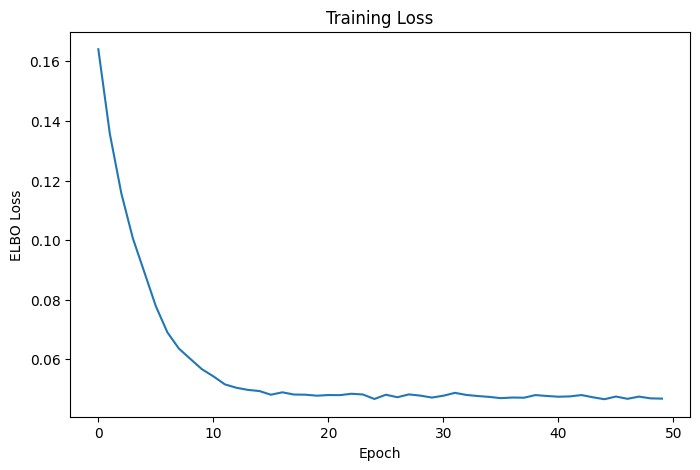

In [72]:
plt.figure(figsize=(8,5))

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("ELBO Loss")

plt.show()


In [73]:
model.eval()

with torch.no_grad():

    sample = torch.randn(5000, 8).to(device)
    generated = model.decoder(sample).cpu().numpy()


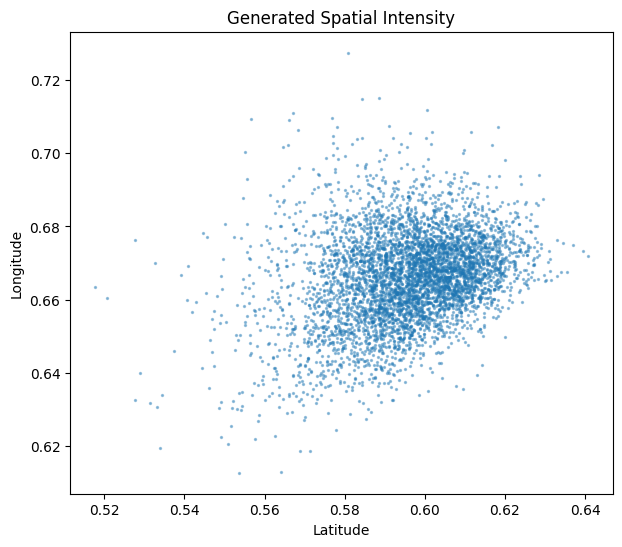

In [74]:
plt.figure(figsize=(7,6))

plt.scatter(
    generated[:,0],  # LAT
    generated[:,1],  # LONG
    s=2,
    alpha=0.4
)

plt.title("Generated Spatial Intensity")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()


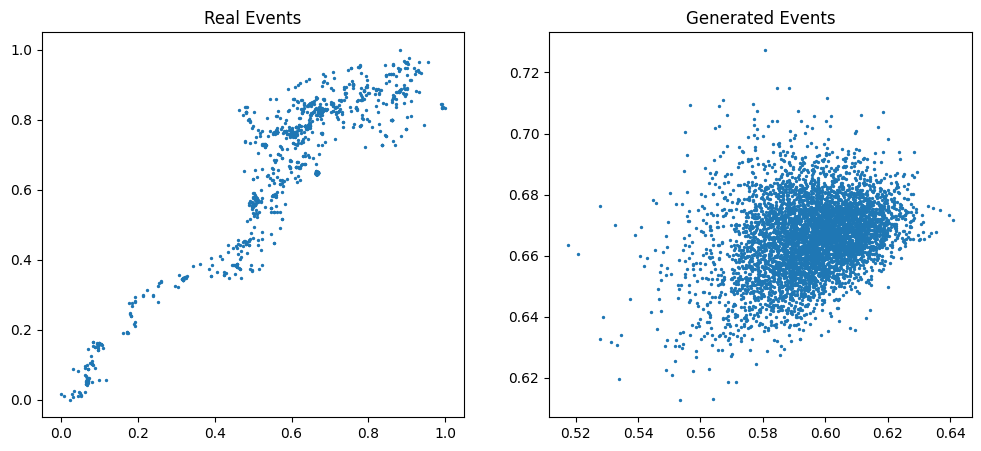

In [75]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(df['LAT'], df['LONG'], s=2)
plt.title("Real Events")

plt.subplot(1,2,2)
plt.scatter(generated[:,0], generated[:,1], s=2)
plt.title("Generated Events")

plt.show()


In [76]:
df = pd.read_csv("final_data_features_scaled.csv")

features = ['LAT', 'LONG', 'DEPTH', 'MAG']
X = df[features].values.astype(np.float32)

tensor_x = torch.tensor(X)

loader = DataLoader(
    TensorDataset(tensor_x),
    batch_size=256,
    shuffle=True
)

In [77]:
def add_noise(x, noise_std=0.05):

    gaussian = torch.randn_like(x) * noise_std

    # simulate missing values
    mask = (torch.rand_like(x) > 0.95).float()

    noisy = x + gaussian
    noisy = noisy * (1 - mask)

    return noisy


In [78]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)


In [79]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [80]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softplus()
        )

    def forward(self, z):
        return self.net(z)


In [81]:
class DVAE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.encoder = Encoder(input_dim)
        self.decoder = Decoder(8, input_dim)

    def forward(self, noisy_x):
        mu, logvar = self.encoder(noisy_x)
        z = reparameterize(mu, logvar)
        recon = self.decoder(z)

        return recon, mu, logvar


In [82]:
def loss_fn(recon, clean, mu, logvar, kappa=10):

    # reconstruction
    recon_loss = nn.MSELoss()(recon, clean)

    # KL
    kl = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    # mass preservation
    mass_real = clean.sum()
    mass_recon = recon.sum()

    mass_penalty = kappa * (mass_real - mass_recon) ** 2 / clean.numel()

    total = recon_loss + kl + mass_penalty

    return total, recon_loss, kl, mass_penalty


In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DVAE(X.shape[1]).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

epochs = 60

loss_hist = []
mass_hist = []

for epoch in range(epochs):

    total_loss = 0
    total_mass = 0

    for batch in loader:

        clean = batch[0].to(device)
        noisy = add_noise(clean)

        optimizer.zero_grad()

        recon, mu, logvar = model(noisy)

        loss, r, k, m = loss_fn(recon, clean, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mass += m.item()

    loss_hist.append(total_loss / len(loader))
    mass_hist.append(total_mass / len(loader))

    print(f"Epoch {epoch+1} | Loss={loss_hist[-1]:.4f}")


Epoch 1 | Loss=369.7538
Epoch 2 | Loss=113.0392
Epoch 3 | Loss=8.6900
Epoch 4 | Loss=19.6478
Epoch 5 | Loss=22.5382
Epoch 6 | Loss=2.8553
Epoch 7 | Loss=2.9255
Epoch 8 | Loss=4.8653
Epoch 9 | Loss=2.4944
Epoch 10 | Loss=1.4008
Epoch 11 | Loss=0.6892
Epoch 12 | Loss=0.6104
Epoch 13 | Loss=0.8067
Epoch 14 | Loss=1.2273
Epoch 15 | Loss=0.2805
Epoch 16 | Loss=0.9947
Epoch 17 | Loss=0.7605
Epoch 18 | Loss=1.3123
Epoch 19 | Loss=1.6248
Epoch 20 | Loss=0.6841
Epoch 21 | Loss=0.4679
Epoch 22 | Loss=0.6511
Epoch 23 | Loss=0.4005
Epoch 24 | Loss=0.8118
Epoch 25 | Loss=0.9047
Epoch 26 | Loss=0.5734
Epoch 27 | Loss=2.2663
Epoch 28 | Loss=0.3391
Epoch 29 | Loss=1.4229
Epoch 30 | Loss=0.2251
Epoch 31 | Loss=0.8348
Epoch 32 | Loss=0.4633
Epoch 33 | Loss=0.7793
Epoch 34 | Loss=0.5366
Epoch 35 | Loss=0.2864
Epoch 36 | Loss=0.2453
Epoch 37 | Loss=0.3857
Epoch 38 | Loss=0.8282
Epoch 39 | Loss=0.5704
Epoch 40 | Loss=0.8938
Epoch 41 | Loss=0.9196
Epoch 42 | Loss=1.1685
Epoch 43 | Loss=0.3723
Epoch 44 | Los

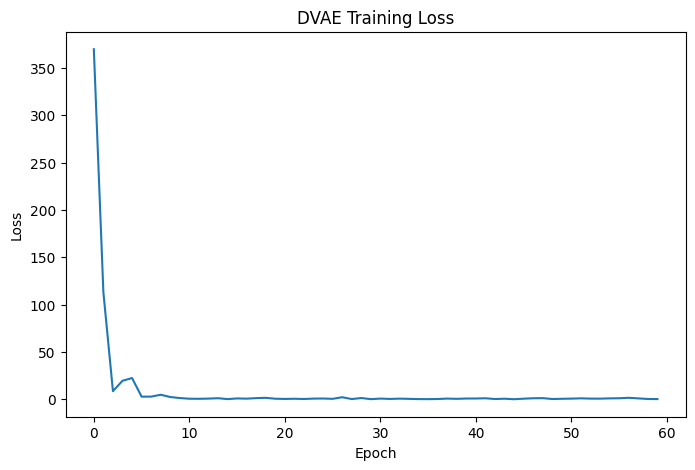

In [84]:
plt.figure(figsize=(8,5))
plt.plot(loss_hist)
plt.title("DVAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


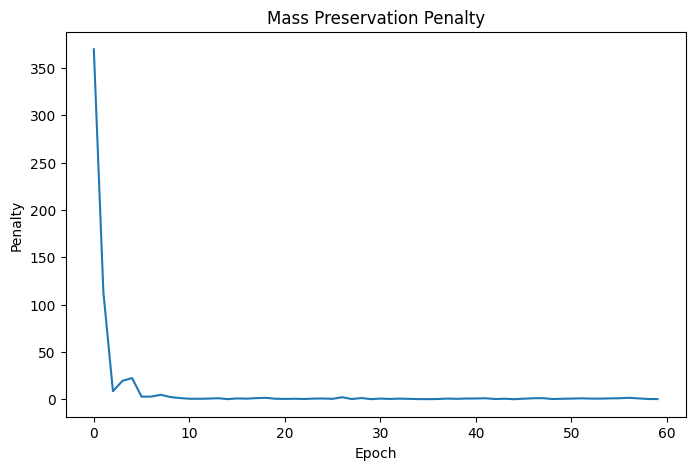

In [86]:
plt.figure(figsize=(8,5))
plt.plot(mass_hist)
plt.title("Mass Preservation Penalty")
plt.xlabel("Epoch")
plt.ylabel("Penalty")
plt.show()


In [87]:
model.eval()

with torch.no_grad():

    sample = tensor_x[:4000].to(device)
    noisy = add_noise(sample)

    recon, _, _ = model(noisy)

    noisy = noisy.cpu().numpy()
    recon = recon.cpu().numpy()
    clean = sample.cpu().numpy()


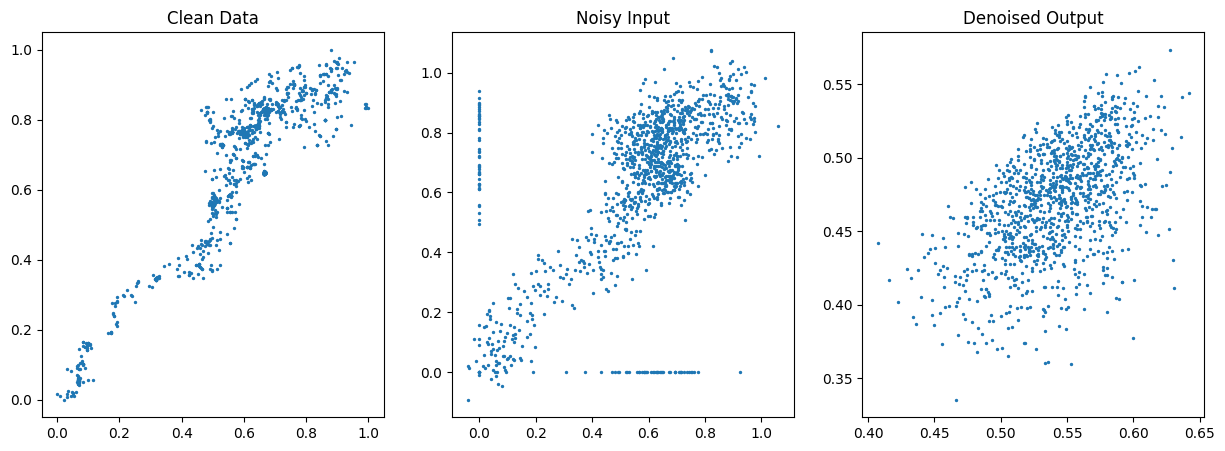

In [88]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(clean[:,0], clean[:,1], s=2)
plt.title("Clean Data")

plt.subplot(1,3,2)
plt.scatter(noisy[:,0], noisy[:,1], s=2)
plt.title("Noisy Input")

plt.subplot(1,3,3)
plt.scatter(recon[:,0], recon[:,1], s=2)
plt.title("Denoised Output")

plt.show()


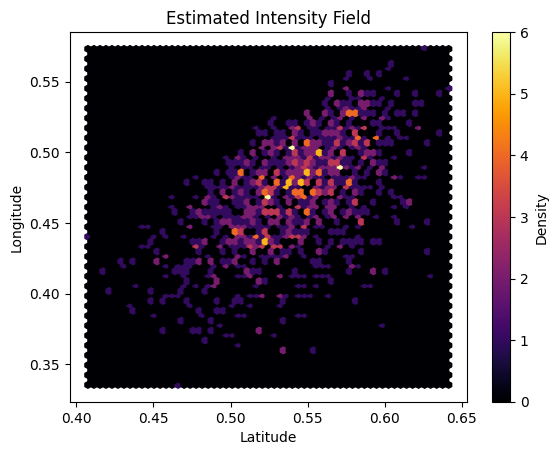

In [89]:
plt.hexbin(
    recon[:,0],
    recon[:,1],
    gridsize=60,
    cmap='inferno'
)

plt.title("Estimated Intensity Field")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.colorbar(label='Density')

plt.show()


In [108]:
df = pd.read_csv("final_data_features_scaled.csv")

df['event_time'] = pd.to_datetime(df['event_time'])

df['TIME'] = (
    df['event_time'] - df['event_time'].min()
).dt.total_seconds()

features = ['LAT','LONG','DEPTH', "TIME"]

X = df[features].values.astype(np.float32)

data = torch.tensor(X)

In [109]:
class IntensityNet(nn.Module):

    def __init__(self, dim=4):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(dim,128),
            nn.ReLU(),

            nn.Linear(128,128),
            nn.ReLU(),

            nn.Linear(128,1),
            nn.Softplus()
        )

    def forward(self,x):
        return self.net(x)


In [110]:
mins = data.min(0).values
maxs = data.max(0).values

volume = torch.prod(maxs - mins)


In [111]:
def monte_carlo_integral(model, M=5000):

    u = torch.rand(M,4)

    samples = mins + u*(maxs-mins)

    lam = model(samples)

    integral = volume * lam.mean()

    return integral


In [112]:
def point_process_loss(model, events):

    lam_events = model(events)

    log_term = torch.log(lam_events + 1e-9).sum()

    integral = monte_carlo_integral(model)

    ll = log_term - integral

    return -ll, log_term.detach(), integral.detach()


In [113]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(4,64),
            nn.ReLU()
        )

        self.mu = nn.Linear(64,4)
        self.logvar = nn.Linear(64,4)

    def forward(self,x):

        h = self.net(x)

        return self.mu(h), self.logvar(h)


In [114]:
class PPVAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.intensity = IntensityNet(4)

    def reparam(self,mu,logvar):

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps*std

    def forward(self,x):

        mu,logvar = self.encoder(x)

        z = self.reparam(mu,logvar)

        lam = self.intensity(x + 0.1*z)

        return lam, mu, logvar


In [100]:
def elbo_loss(model,events):

    lam, mu, logvar = model(events)

    log_term = torch.log(lam + 1e-9).sum()

    integral = monte_carlo_integral(
        lambda u: model.intensity(u)
    )

    ll = log_term - integral

    KL = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    loss = -ll + KL

    return loss, ll.detach(), KL.detach()


In [121]:
model = PPVAE()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

losses=[]
kls=[]
lls=[]

for epoch in range(80):

    optimizer.zero_grad()

    loss,ll,kl = elbo_loss(model,data)

    if torch.isnan(loss):
        print("LOSS IS NAN")

    if torch.isnan(ll):
        print("LL IS NAN")

    if torch.isnan(kl):
        print("KL IS NAN")


    loss.backward()

    optimizer.step()

    losses.append(loss.item())
    kls.append(kl.item())
    lls.append(ll.item())

    print(epoch,loss.item())


LOSS IS NAN
LL IS NAN
0 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
1 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
2 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
3 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
4 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
5 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
6 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
7 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
8 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
9 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
10 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
11 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
12 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
13 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
14 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
15 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
16 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
17 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
18 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
19 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
20 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
21 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
22 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
23 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
24 nan
LOSS IS NAN
LL IS NAN
KL IS NAN
25 nan
LOSS I

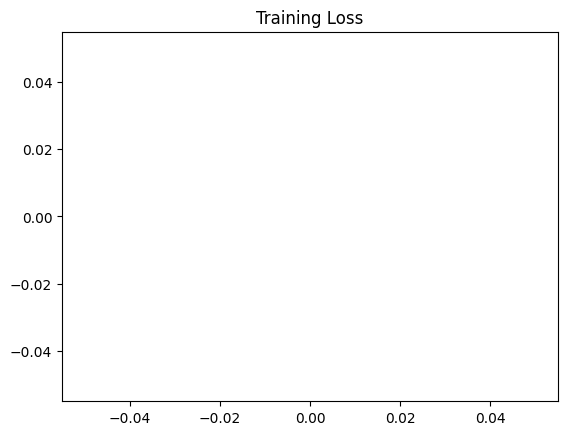

In [116]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()


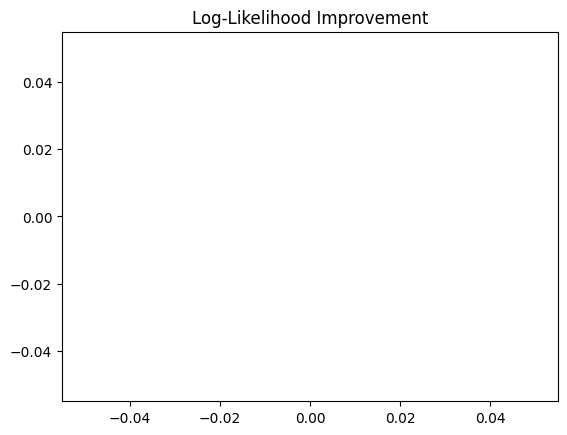

In [117]:
plt.plot(lls)
plt.title("Log-Likelihood Improvement")
plt.show()


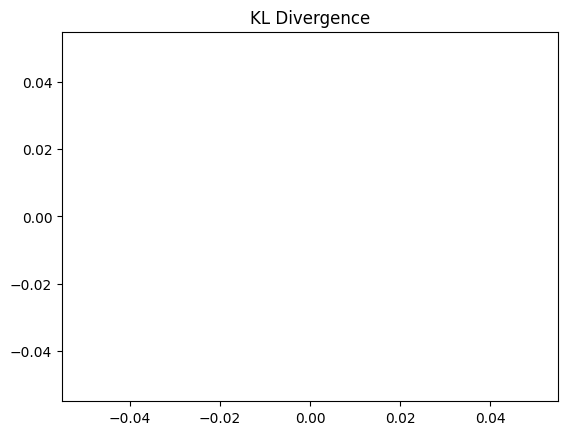

In [118]:
plt.plot(kls)
plt.title("KL Divergence")
plt.show()


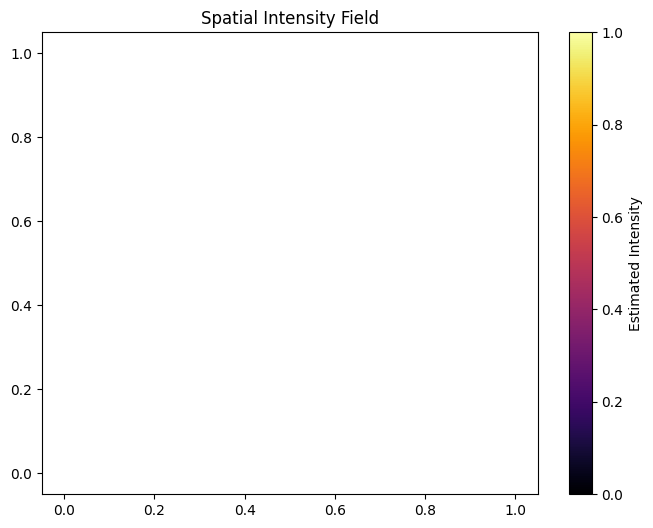

In [119]:
model.eval()

grid = 120

lat = np.linspace(mins[0],maxs[0],grid)
lon = np.linspace(mins[1],maxs[1],grid)

mesh = np.array(
    [[i,j,0.5,0.5] for i in lat for j in lon],
    dtype=np.float32
)

mesh = torch.tensor(mesh)

with torch.no_grad():

    intensity = model.intensity(mesh).numpy()

plt.figure(figsize=(8,6))

plt.hexbin(
    mesh[:,0],
    mesh[:,1],
    C=intensity.flatten(),
    gridsize=60,
    cmap='inferno'
)

plt.colorbar(label='Estimated Intensity')

plt.title("Spatial Intensity Field")

plt.show()


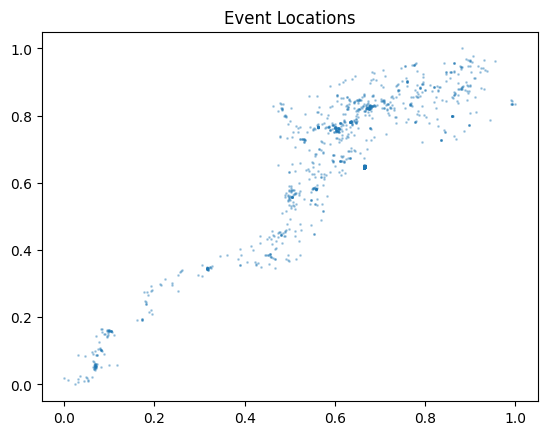

In [120]:
plt.scatter(
    X[:,0],
    X[:,1],
    s=1,
    alpha=0.3
)

plt.title("Event Locations")

plt.show()
